# Actividad Práctica N°1: Representación de Sistemas y Control PID

Para el desarrollo de las posteriores actividades se utilizará Python, por lo que a continuación se importarán los paquetes a utilizar.

In [3]:
from IPython.display import Image
from scipy import signal
from control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import cv2

## Caso de estudio 1. Sistema de dos variables de estado.

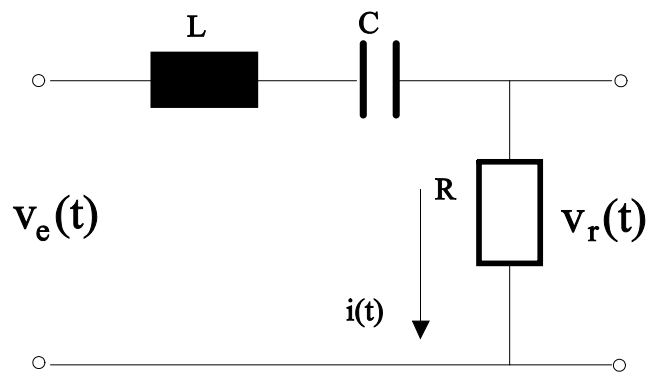

In [4]:
Image(filename='images/rclCircuit.PNG')

Sea el sistema eléctrico de la figura anterior, con las representaciones en variables de estado:

$ \dot{x} = Ax(t)+bu(t)$

$ y=c^T x(t) $

donde las matrices contienen a los coeficientes del circuito,

$ A = \begin{bmatrix} -R/L & -1/L \\ 1/C & 0 \end{bmatrix}
$,
$ b = \begin{bmatrix} 1/L \\ 0 \end{bmatrix}
$,
$ c^T = \begin{bmatrix} R & 0 \end{bmatrix}
$

A continuación, las curvas del circuito RCL para una entrada de $12V$

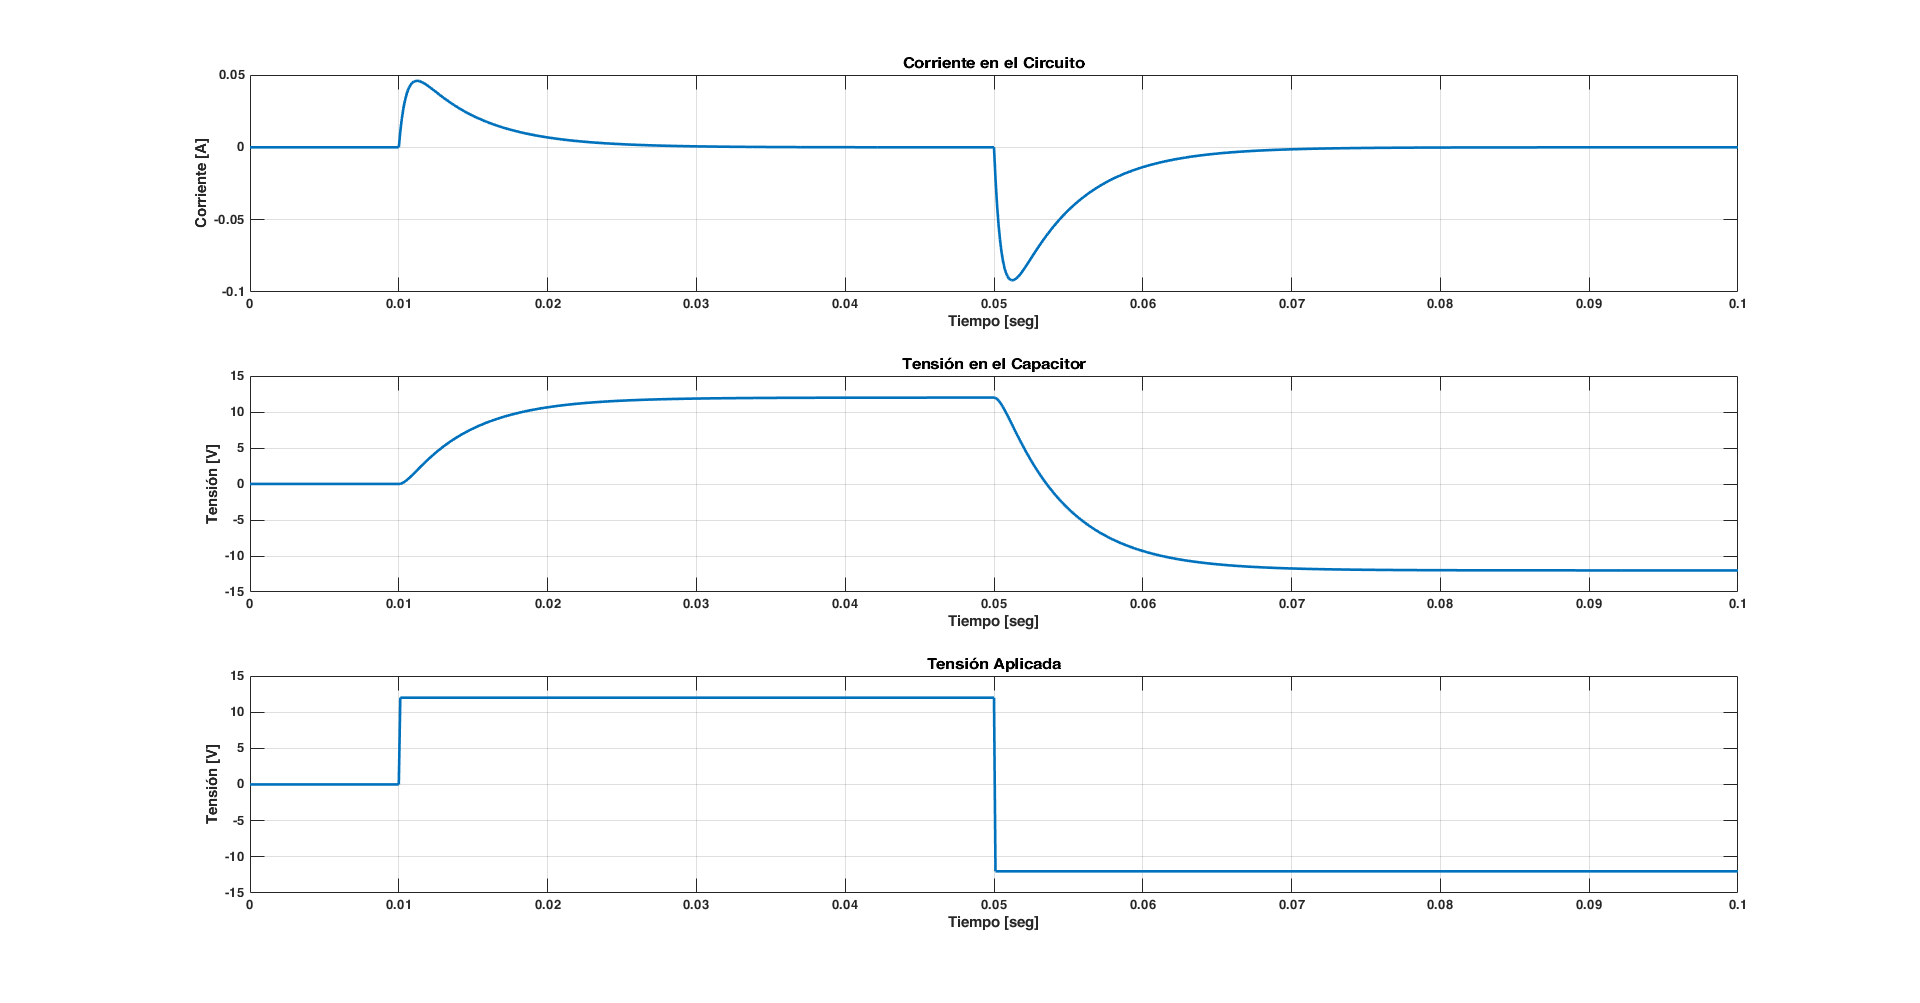

In [5]:
Image(filename='images/corrienteCapacitorTension.png')

En primera instancia, se deben asignar los siguientes valores:

- $ R = 4,7 k\Omega $ 
- $ L = 10 \mu Hy $
- $ C = 100 nF $

Luego de eso, se deben obtener simulaciones que permitan estudiar la dinámica del sistema, con una entrada de tensión escalón de 12V, que cada 1ms cambia de signo. Para ello, se colocan los valores de las variables asignados anteriormente para realizar la simulación.

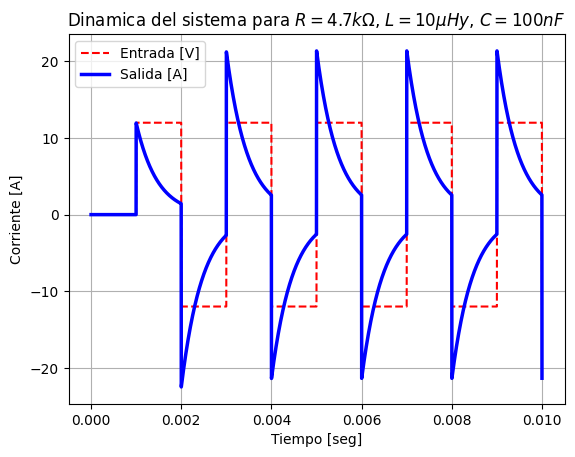

In [65]:
R = 4700
L = 0.00001
C = 0.0000001

A = [[-R/L, -1/L], [1/C, 0]]
B = [[1/L], [0]]  
C = [R, 0]
D = 0

sys = signal.StateSpace(A,B,C,D)

t = np.linspace(0, 0.01, 5000)
u = np.piecewise(t, [t<=0.001, t>0.001], [lambda t: 0*t, lambda t: 12*signal.square(2 * np.pi * 500 * (t - 0.001))])

t1,y1,x1 = signal.lsim(sys,u,t)

plt.plot(t, u, 'r--')
plt.plot(t1, y1, 'b-', linewidth=2.5)
plt.grid()
plt.xlabel('Tiempo [seg]')
plt.ylabel('Corriente [A]')
plt.title('Dinamica del sistema para $R=4.7k\Omega$, $L=10\mu Hy$, $C=100nF$')
plt.legend(['Entrada [V]', 'Salida [A]'], loc='best')

Luego, se pide asignar otros valores para los componentes pasivos del circuito RCL:

- $R = 5.6k\Omega$
- $L = 10\mu Hy$
- $C = 100nF$

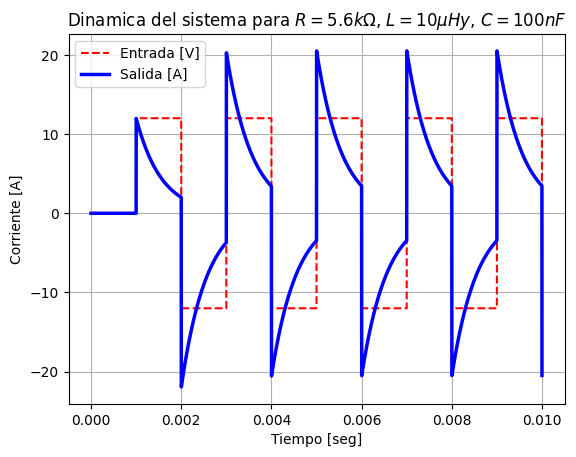

In [57]:
R = 5600
L = 0.00001
C = 0.0000001

A = [[-R/L, -1/L], [1/C, 0]]
B = [[1/L], [0]]  
C = [R, 0]
D = 0

sys = signal.StateSpace(A,B,C,D)

t = np.linspace(0, 0.01, 10000)
u = np.piecewise(t, [t<=0.001, t>0.001], [lambda t: 0*t, lambda t: 12*signal.square(2 * np.pi * 500 * (t - 0.001))])

t1,y1,x1 = signal.lsim(sys,u,t)

plt.plot(t, u, 'r--')
plt.plot(t1, y1, 'b-', linewidth=2.5)
plt.grid()
plt.xlabel('Tiempo [seg]')
plt.ylabel('Corriente [A]')
plt.title('Dinamica del sistema para $R=5.6k\Omega$, $L=10\mu Hy$, $C=100nF$')
plt.legend(['Entrada [V]', 'Salida [A]'], loc='best')

Posteriormente, se pide deducir los valores de R, L y C del circuito simulado por el Profesor. Para ello se utilizará el método de la respuesta al escalón, tomando como salida a la tensión medida a bornes del capacitor. Esta información se encuentra disponible en `resources\Curvas_Medidas_RLC.xls`. 

Se grafica la curva de tensión en el capacitor:

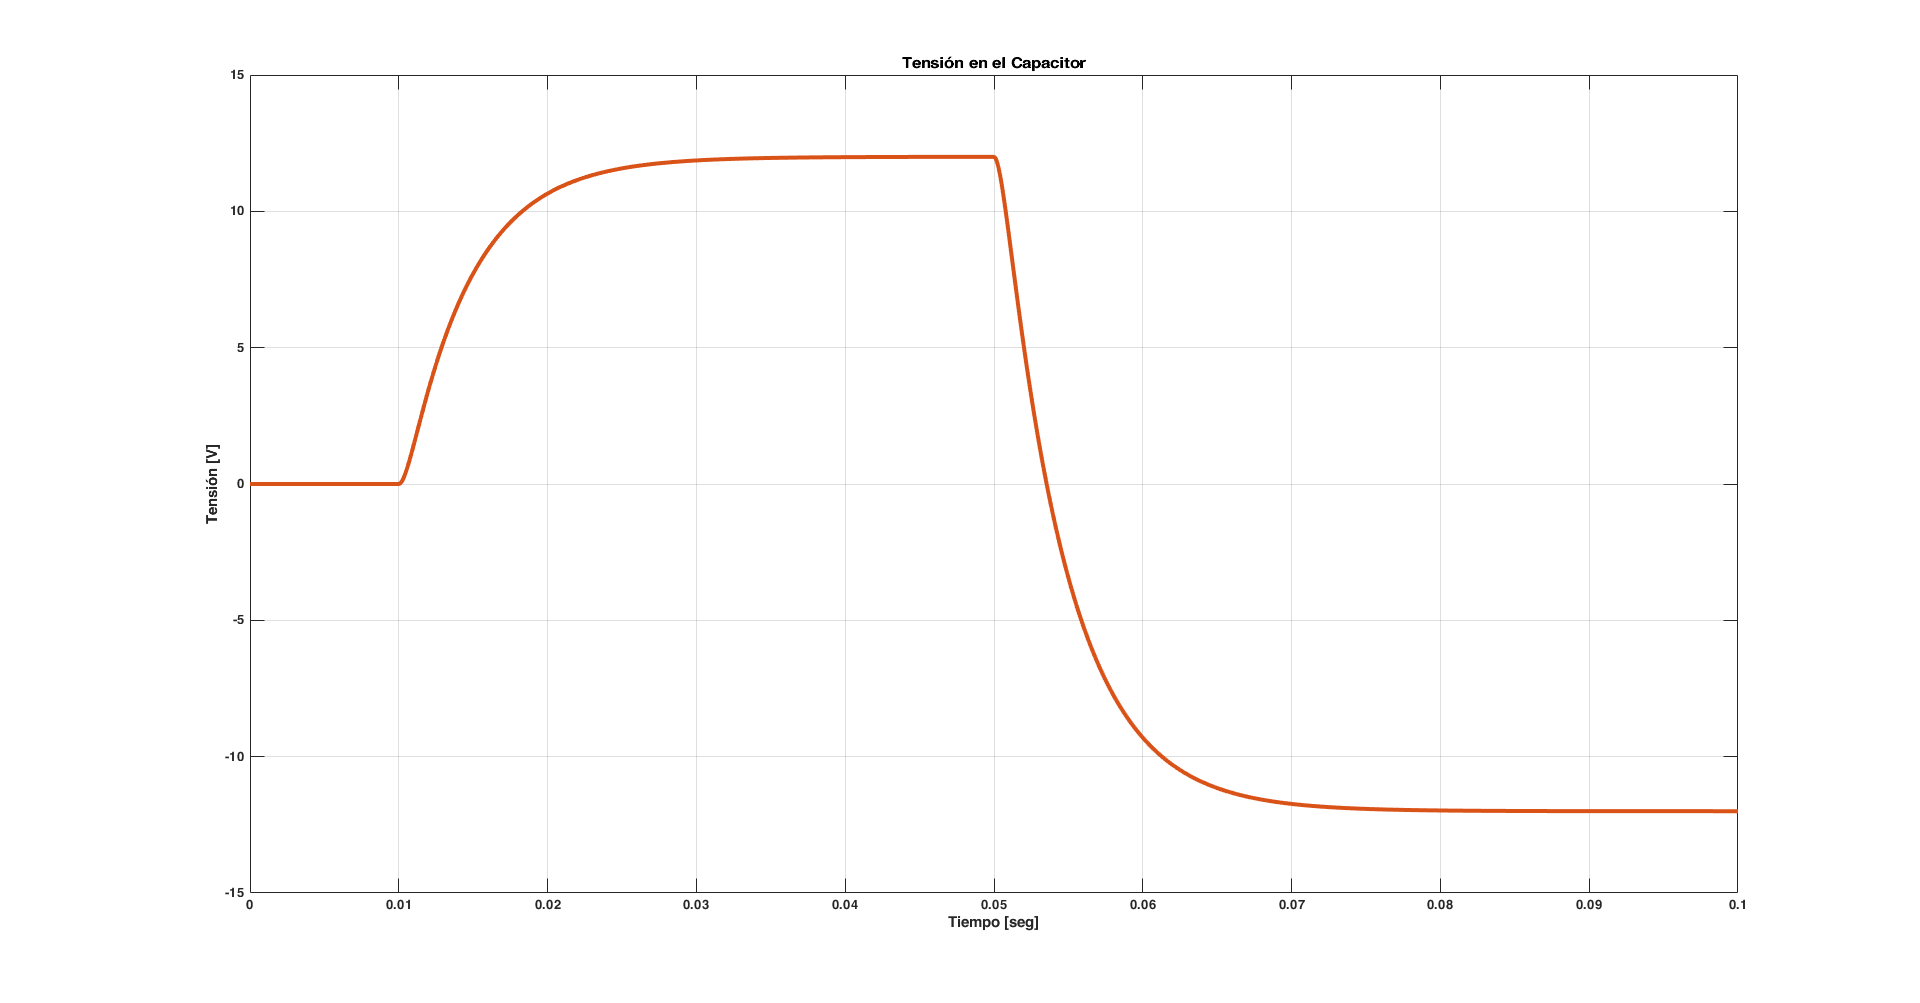

In [6]:
Image(filename='images/tensionCapacitor.png')

Y luego, se muestra la gráfica de la corriente en el circuito.

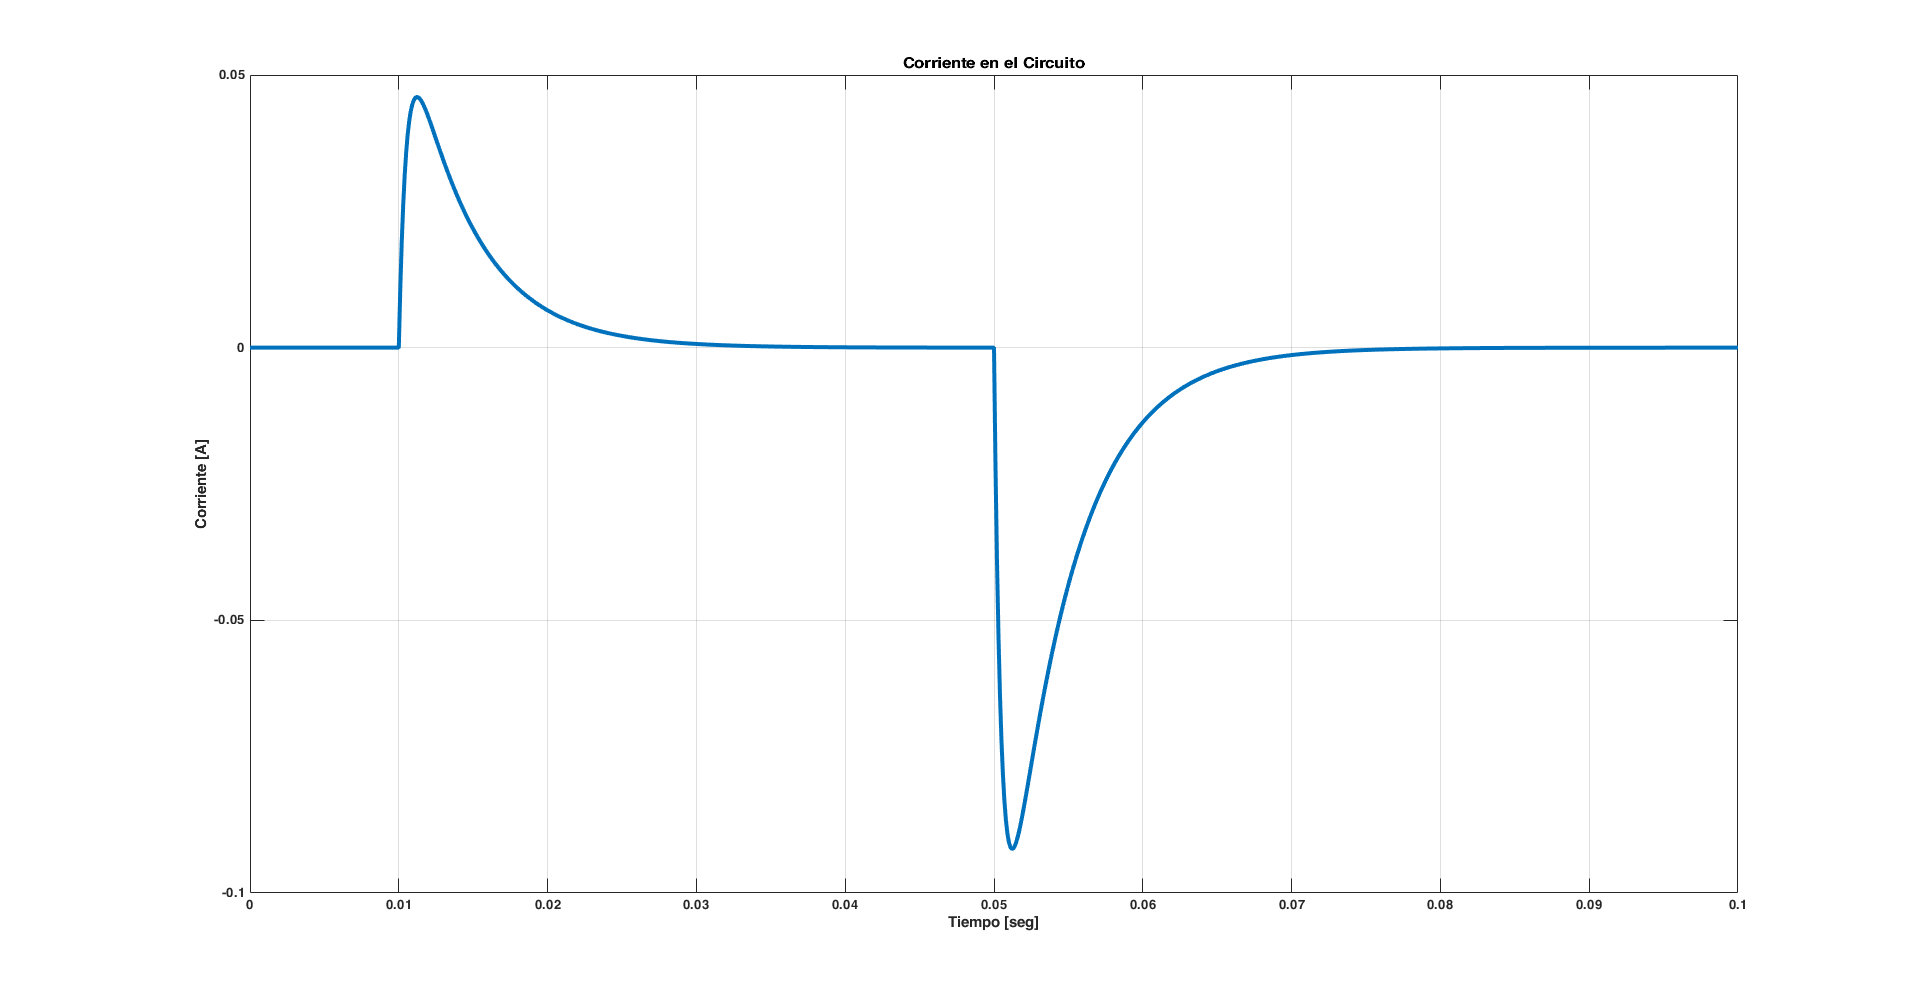

In [7]:
Image(filename='images/corriente.png')

Se tienen las siguientes definiciones para el problema en cuestión:

- $ u(t)=v_e(t) $
- $ y(t)=v_c(t) $

En donde se puede expresar también que $ x(t) = \begin{bmatrix} x_1 & x_2 \end{bmatrix} $ con:

- $ x_1 = i(t) $
- $ x_2 = v_c(t) $ 

Se puede escribir:

- $ \dot{x} = \begin{bmatrix} -R/L & -1/L \\ 1/C & 0 \end{bmatrix} * \begin{bmatrix} i(t) \\ v_c(t) \end{bmatrix} + \begin{bmatrix} 1/L \\ 0 \end{bmatrix} * v_e(t) $
- $ y = \begin{bmatrix} R \\ 0 \end{bmatrix} * \begin{bmatrix} i(t) & v_c(t) \end{bmatrix} $

Las anteriores expresiones brindan información sobre la dinámica del sistema a simular. Es por eso que, teniendo en cuenta que el vector se define como:

$ \dot{x} = \begin{bmatrix} \frac{di(t)}{dt} \\ \frac{dv_c(t)}{dt} \end{bmatrix} $

Se pueden extraer las expresiones correspondientes a la corriente y a la tensión en el capacitor mediante una simple resolución de la suma de matrices, obteniéndose así:

- $ \frac{di(t)}{dt} = \frac{v_e(t) - v_c(t) - Ri(t)}{L} $
- $ \frac{dv_c(t)}{dt} = \frac{i(t)}{C} $



Se aplica la transformada de Laplace a las dos ecuaciones diferenciales anteriores, obteniéndose así:

- $ sI(s) = \frac{1}{L} (V_e(s)-V_c(t)-RI(s)) $
- $ sV_c(s) = \frac{1}{C} I(s) $

Se puede despejar $I(s)$ en cada una de las ecuaciones, para después igualar y obtener la función de transferencia de la tensión en el capacitor. Para ello, nuevamente se utilizará Python, esta vez con el paquete simbólico.

In [45]:
s,I,R,L,C,Ve,Vc = sym.symbols('s I R L C Ve Vc')
eq1 = sym.Eq(s*I,(1/L)*(Ve-Vc-R*I))
eq2 = sym.Eq(s*Vc,(1/C)*I)
I1 = sym.solve(eq1, I)
I2 = sym.solve(eq2, I)

print('Despeje de la corriente en la primera ecuación',I1)
print('Despeje de la corriente en la segunda ecuación',I2)

Despeje de la corriente en la primera ecuación [(-Vc + Ve)/(L*s + R)]
Despeje de la corriente en la segunda ecuación [C*Vc*s]


Se igualan los resultados obtenidos:

In [50]:
eq3 = sym.Eq((-Vc + Ve)/(L*s + R),C*Vc*s)
Vcap = sym.solve(eq3,Vc)
print(Vcap)

[Ve/(C*L*s**2 + C*R*s + 1)]


Con la función de transferencia obtenida en el punto anterior no es cómodo trabajar, por lo que se la simplifica.

In [49]:
print(sym.simplify((Ve/(C*L*s**2 + C*R*s + 1))/Ve))

1/(C*L*s**2 + C*R*s + 1)


Es decir,

$G(s)= \frac{1}{LCs^2+CRs+1}$

Se puede apreciar que la función de transferencia del sistema es de segundo órden, además, por la forma de la respuesta al impulso de la misma, es posible inferir que tiene dos polos reales y distintos. Para reconocer esta función de transferencia, se utiliza el método de Chen. Para ello se plantea un sistema de tres ecuaciones, pero además se deben fijar tres puntos en los que se analizará el sistema.

La primera aproximación a la función de transferencia, se realiza mediante una aproximación de una función de transferencia de segundo órden a una de primero. Con ello, se elabora el siguiente código: